In [144]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as spsp
import scipy.sparse.linalg as splinalg

class DiffOperator:
    def __init__(self, n):
        self.N = n
        self.h = 1.0 / (n + 1)
        self.X = np.linspace(0, 1, n + 2)
        
        self.D2 = (1.0/(self.h)**2) * spsp.diags([1, -2, 1], [-1, 0, 1], shape=(n, n))
        self.RHS = [self.func_rhs(self.X[i]) for i in range(1, n + 1)]
        self.SOL = [self.func_solution(self.X[i]) for i in range(1, n + 1)]
        
    def func_solution(self, x):
        return x*(1 - x)
    
    def func_rhs(self, x):
        return 2 - np.sin(x*(1 - x))
        
    def apply(self, u):
        return self.D2.dot(u) + np.sin(u) + self.RHS
    
    def J(self, u):
        return self.D2 + spsp.diags(np.cos(u), 0)
    
    def J_approx(self, u, h):
        unorm = np.linalg.norm(u)
        e = np.eye(self.N)
        if unorm == 0:
            return np.array([ (self.apply(u + h*e[i]) - self.apply(u)) / (h) for i in range(0, self.N) ]).transpose()
        else:
            return np.array([ (self.apply(u + h*unorm*e[i]) - self.apply(u)) / (h*unorm) for i in range(0, self.N) ]).transpose()
        
        

In [145]:
D = DiffOperator(5)
u = [1, 2, 3, 4, 5]
print(D.D2.todense())
print( )
print(D.J(u).todense())
print( )
print(D.J_approx(u, 1e-5))

[[-72.  36.   0.   0.   0.]
 [ 36. -72.  36.   0.   0.]
 [  0.  36. -72.  36.   0.]
 [  0.   0.  36. -72.  36.]
 [  0.   0.   0.  36. -72.]]

[[-71.45969769  36.           0.           0.           0.        ]
 [ 36.         -72.41614684  36.           0.           0.        ]
 [  0.          36.         -72.9899925   36.           0.        ]
 [  0.           0.          36.         -72.65364362  36.        ]
 [  0.           0.           0.          36.         -71.71633781]]

[[-71.4597289   36.           0.           0.           0.        ]
 [ 36.         -72.41618055  36.           0.           0.        ]
 [  0.          36.         -72.98999773  36.           0.        ]
 [  0.           0.          36.         -72.65361556  36.        ]
 [  0.           0.           0.          36.         -71.71630226]]


In [156]:
# Newton method with analytical J
def newton_true(D, atol, rtol, maxiters):
    n = D.N
    u = np.zeros(n)
    r0 = np.linalg.norm(D.apply(u))
    r = r0
    iters = 0
    errs_newtontrue = []

    while r > rtol*r0 + atol and iters < maxiters:
        s = spsp.linalg.spsolve(D.J(u), -D.apply(u))
        u = u + s
        r = np.linalg.norm(D.apply(u))
        errs_newtontrue.append(np.linalg.norm(D.SOL - u))
        iters = iters + 1

    return iters, errs_newtontrue
        
atol = 1e-10; rtol = 1e-8; maxiters = 1000
n = 40
D = DiffOperator(n)
iters, errs_newtontrue = newton_true(D, atol, rtol, maxiters)
print("Iterations: %d and final error: %e" % (iters, errs_newtontrue[-1]))

Iterations: 2 and final error: 2.673135e-09


In [157]:
# Newton method with approx J
def newton_approx(D, atol, rtol, h, maxiters):
    n = D.N
    u = np.zeros(n)
    r0 = np.linalg.norm(D.apply(u))
    r = r0
    iters = 0
    errs_newtonapprox = []

    while r > rtol*r0 + atol and iters < maxiters:
        s = np.linalg.solve(D.J_approx(u, h), -D.apply(u))
        u = u + s
        r = np.linalg.norm(D.apply(u))
        errs_newtonapprox.append(np.linalg.norm(D.SOL - u))
        iters = iters + 1

    return iters, errs_newtonapprox

atol = 1e-10; rtol = 1e-8; h = 1e-5; maxiters = 1000
n = 40
D = DiffOperator(n)
iters, errs_newtonapprox = newton_approx(D, atol, rtol, h, maxiters)
print("Iterations: %d and final error: %e" % (iters, errs_newtonapprox[-1]))

Iterations: 2 and final error: 2.823722e-09


In [149]:
# Broyden Method
def broyden(D, atol, rtol, maxiters):
    n = D.N
    u = np.zeros(n)
    r0 = np.linalg.norm(D.apply(u))
    r = r0
    B = np.eye(n)

    iters = 0
    errs_broyden = []

    while r > rtol*r0 + atol and iters < maxiters:
        s = np.linalg.solve(B, -D.apply(u))
        u = u + s
        r = np.linalg.norm(D.apply(u))
        B = B + (D.apply(u).reshape(n, 1)).dot(s.reshape(1, n)) / s.dot(s)
        errs_broyden.append(np.linalg.norm(D.SOL - u))
        iters = iters + 1

    return iters, errs_broyden

atol = 1e-10; rtol = 1e-8; maxiters = 1000
n = 40
D = DiffOperator(n)
iters, errs_broyden = broyden(D, atol, rtol, maxiters)
print("Iterations: %d and final error: %e" % (iters, errs_broyden[-1]))

Iterations: 91 and final error: 5.760204e-12


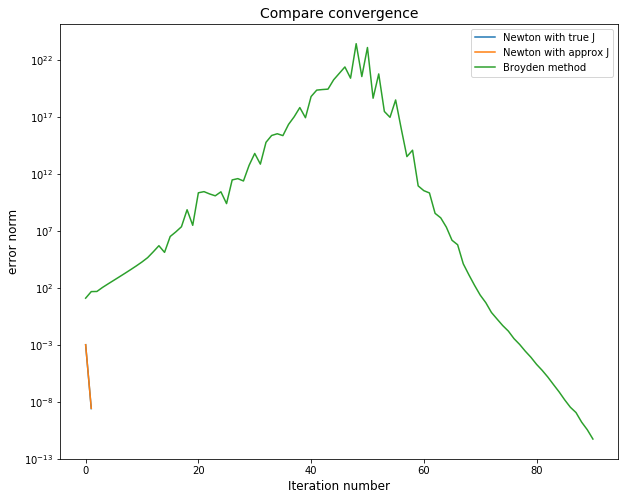

In [158]:
plt.figure(figsize=(10, 8))
plt.plot(errs_newtontrue, label="Newton with true J")
plt.plot(errs_newtonapprox, label="Newton with approx J")
plt.plot(errs_broyden, label="Broyden method")
plt.title("Compare convergence", fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.yscale('log')
plt.ylabel("error norm", fontsize=12)
plt.legend()
